In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
pd.set_option('display.max_columns', 500)
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy.random
import statsmodels.nonparametric
import scipy.stats

In [8]:
bets = pd.read_csv('../../../data/datasets_for_analysis/final_datasets/odds_w_outcomes.csv')
bets['Card_Date'] = pd.to_datetime(bets['Card_Date'] )
bets['year'] = bets['Card_Date'].dt.year

In [9]:
# convert decimal odds to probabilities using the balanced book method
betting_sites= ['5Dimes','BetDSI','BookMaker','SportBet','Bet365','Bovada', 
                'Sportsbook','William_H','Pinnacle','SportsInt','BetOnline','Intertops']

for col in betting_sites:
    bets[col+"_prob"] =  ((bets[col]**-1) - bets[col+"_vig"])/(1-bets[col+"_vig"]) 

bets["avg_prob"] = bets[[col+"_prob" for col in betting_sites]].apply("mean", axis = 1)

In [10]:
# look at 2013 - 2020 30% - 50% probability range
bets_recent = bets[(bets.year >= 2013)& (bets.avg_prob >= .3) & (bets.avg_prob <= .5)].copy()
bets_recent.Card_Cleaned.value_counts()

Prelim        1274
Main Event     898
Name: Card_Cleaned, dtype: int64

In [23]:
bets_recent['bet_won_main'] = np.where(bets_recent.Card_Cleaned == 'Prelim', np.nan, bets_recent.bet_won)
bets_recent['bet_won_prelim'] = np.where(bets_recent.Card_Cleaned == 'Prelim',  bets_recent.bet_won, np.nan)
bins = np.arange(.3,.5, .025)
divided = pd.IntervalIndex.from_tuples([(bins[i], bins[i+1]) for i in np.arange(len(bins) - 1)])
consensus_group = pd.cut(bets_recent.avg_prob, divided)
grouped = bets_recent.groupby(consensus_group)['bet_won_main', 'bet_won_prelim', 'avg_prob'].agg(avg_prob = ('avg_prob', 'mean'),
                                                                   bet_won_main=('bet_won_main', 'mean'),
                                                                   num_bet_won_main =  ('bet_won_main', 'sum'), 
                                                                    bet_won_prelim=('bet_won_prelim', 'mean'),
                                                                   num_bet_won_prelim =  ('bet_won_prelim', 'sum'),
                                                                      n_main = ('bet_won_main', 'count'),
                                                                      n_prelim = ('bet_won_prelim', 'count'),
                                                                      n = ('avg_prob','size')   
                                                                                                )
grouped['diff_main'] = grouped['bet_won_main'] - grouped['avg_prob']
grouped['diff_prelim'] = grouped['bet_won_prelim'] - grouped['avg_prob']
grouped['p_val_main'] = grouped.apply(lambda x: statsmodels.stats.proportion.binom_test(x.num_bet_won_main, x.n_main, x.avg_prob), axis = 1)
grouped['p_val_prelim'] = grouped.apply(lambda x: statsmodels.stats.proportion.binom_test(x.num_bet_won_prelim, x.n_prelim, x.avg_prob), axis = 1)

del grouped['num_bet_won_main'], grouped['num_bet_won_prelim']
display(grouped[['diff_main', 'p_val_main', 'n_main', 'diff_prelim', 'p_val_prelim', 'n_prelim', 'n']])

,diff_main,p_val_main,n_main,diff_prelim,p_val_prelim,n_prelim,n
avg_prob,,,,,,,
"(0.3, 0.325]",0.047657,0.331401,100,-0.004650,1.000000,130,230
"(0.325, 0.35000000000000003]",0.041720,0.342511,124,-0.040760,0.334184,145,269
"(0.35000000000000003, 0.37500000000000006]",0.047315,0.349485,100,0.070649,0.074827,150,250
"(0.37500000000000006, 0.4000000000000001]",0.095137,0.020568,143,0.034241,0.365212,185,328
"(0.4000000000000001, 0.4250000000000001]",0.088351,0.041969,132,0.031594,0.411346,185,317
"(0.4250000000000001, 0.4500000000000001]",0.126879,0.007091,119,-0.044842,0.266473,161,280
"(0.4500000000000001, 0.47500000000000014]",0.006921,0.920309,100,-0.002040,1.000000,154,254


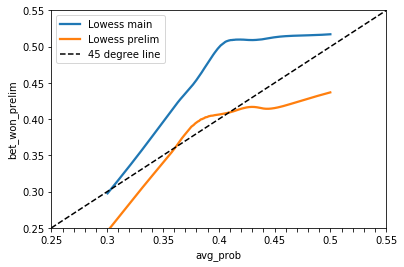

In [27]:

fig, ax = plt.subplots()
sns.regplot('avg_prob', 'bet_won_main', data = bets_recent, 
            scatter = False, lowess = True, ax = ax, label = 'Lowess main')
sns.regplot('avg_prob', 'bet_won_prelim', data = bets_recent, 
            scatter = False, lowess = True, ax = ax, label = 'Lowess prelim')
x = np.linspace(.25, .55, 100)
ax.plot(x, x, 'k--',label = '45 degree line')
ax.set_xticks(np.arange(.25,.56,.01))
ax.set_ylim(.25,.55)
ax.set_xlim(.25,.55)
ax.set_xticklabels([round(x,2) if i%5 == 0 else '' for i, x in enumerate(np.arange(.25,.56,.01))])
ax.legend(loc='best')

It looks like most of the overperformance is coming from fighters fighting on the main card. This might be a case of their opponents being overhyped. 